## Carregando as bibliotecas e os dados

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
# Carregando e ajustando os dados
data = pd.read_csv("../data.csv")
data["week"] = pd.to_datetime(data["week"])
data_series = data.set_index("week")["volume"]

print(data_series.head())

week
2022-10-31    0.33
2022-11-07    0.47
2022-11-14    0.32
2022-11-21    1.69
2022-11-28    1.23
Name: volume, dtype: float64


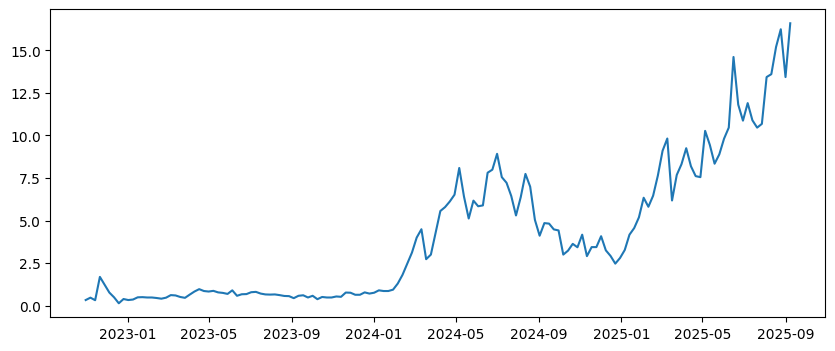

In [5]:
# Exibindo os dados
plt.figure(figsize = (10, 4))
plt.plot(data_series)
plt.show()

## Avaliando a decomposição da série em tendência e sazonalidade

Primeiramente, vamos avaliar a existência de padrões de tendência e de sazonalidade nessa série de dados. Para isso, calculamos suas autocorrelações, que estão exibidas abaixo.

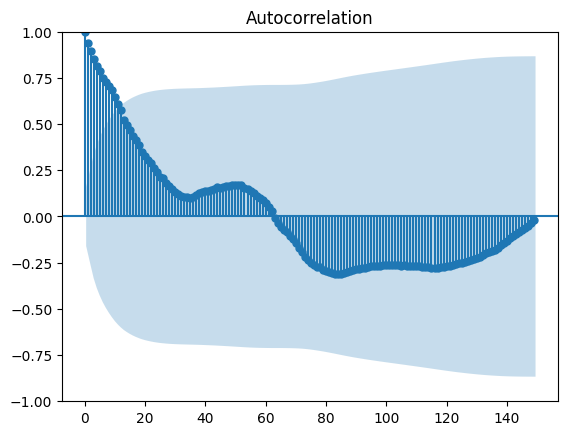

In [6]:
# Calculando e exibindo a função de autocorrelação
plot_acf(data_series, lags = 149)
plt.show()

Analisando o gráfico, podemos concluir que há um forte indício da existência de tendência nesse conjunto de dados, o que pode ser constatado pela alta correlação entre valores temporalmente próximos que diminui lentamente até valores maiores de lag. Por outro lado, não há sinal de sazonalidade, já que não existem picos significativos de autocorrelação além do presente em lags menores.

Isso pode ser mais profundamente testado por meio da efetiva decomposição desse dado nas três componentes temporais (tendência, sazonalidade e resíduo) e da observação do comportamento dos resíduos resultantes. Nos gráficos abaixo, realizamos a decomposição com janelas temporais de 4 semanas (ciclo mensal) e de 52 semanas (ciclo anual).

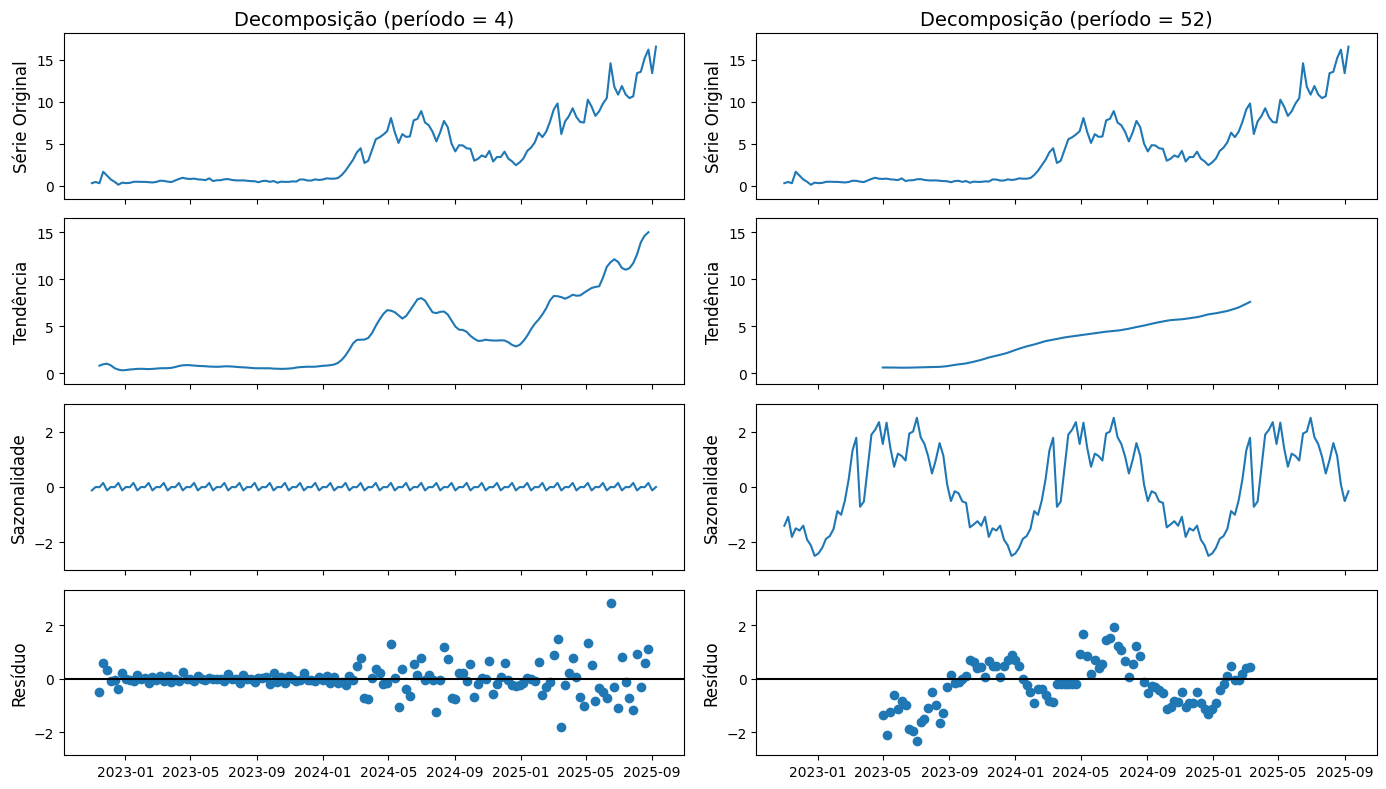

In [7]:
# Fazendo a decomposição da série nas duas janelas de interesse
decomposition_4_weeks = seasonal_decompose(data_series, model = "additive", period = 4)
decomposition_52_weeks = seasonal_decompose(data_series, model = "additive", period = 52)

fig, axes = plt.subplots(4, 2, figsize=(14, 8), sharex=True)

components_4 = [decomposition_4_weeks.observed,
                decomposition_4_weeks.trend,
                decomposition_4_weeks.seasonal,
                decomposition_4_weeks.resid]

components_52 = [decomposition_52_weeks.observed,
                 decomposition_52_weeks.trend,
                 decomposition_52_weeks.seasonal,
                 decomposition_52_weeks.resid]

min_data = min(data_series)
max_data = max(data_series)
min_trend = min(min(components_4[1].dropna()), min(components_52[1].dropna()))
max_trend = max(max(components_4[1].dropna()), max(components_52[1].dropna()))
min_seasonal = min(min(components_4[2].dropna()), min(components_52[2].dropna()))
max_seasonal = max(max(components_4[2].dropna()), max(components_52[2].dropna()))
min_residuals = min(min(components_4[3].dropna()), min(components_52[3].dropna()))
max_residuals = max(max(components_4[3].dropna()), max(components_52[3].dropna()))

titles = ['Série Original', 'Tendência', 'Sazonalidade', 'Resíduo']
lims = [(min_data, max_data), (min_trend, max_trend), (min_seasonal, max_seasonal), (min_residuals, max_residuals)]

for i in range(4):
    if i < 3:
        axes[i, 0].plot(components_4[i])
    else:
        axes[i, 0].scatter(data_series.index, components_4[i])
        axes[i, 0].axhline(0, color = "black")

    axes[i, 0].set_ylim((lims[i][0] - 0.1*(lims[i][1]-lims[i][0]), lims[i][1] + 0.1*(lims[i][1]-lims[i][0])))
    axes[i, 0].set_ylabel(titles[i], fontsize = 12)

for i in range(4):
    if i < 3:
        axes[i, 1].plot(components_52[i])
    else:
        axes[i, 1].scatter(data_series.index, components_52[i])
        axes[i, 1].axhline(0, color = "black")

    axes[i, 1].set_ylim((lims[i][0] - 0.1*(lims[i][1]-lims[i][0]), lims[i][1] + 0.1*(lims[i][1]-lims[i][0])))
    axes[i, 1].set_ylabel(titles[i], fontsize = 12) 
    
# 5. Adicione títulos específicos para as colunas e remova títulos individuais do subplot
axes[0, 0].set_title('Decomposição (período = 4)', fontsize = 14)
axes[0, 1].set_title('Decomposição (período = 52)', fontsize = 14)

# 6. Ajuste o layout
plt.tight_layout()
plt.show()

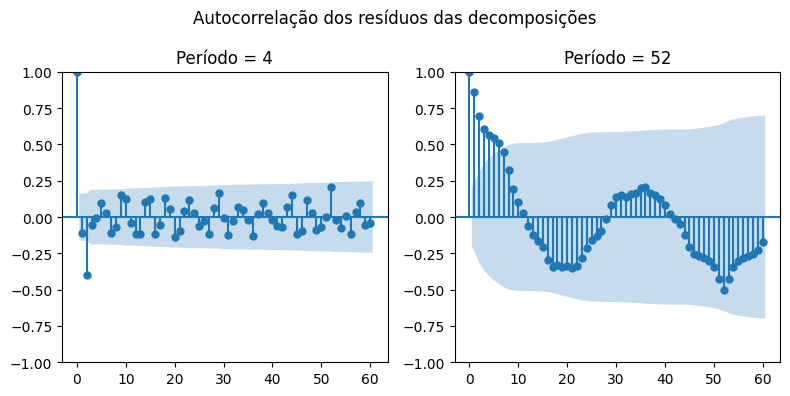

In [8]:
# Pegando os resíduos não nulos das decomposições e plotando suas ACFs
residuals_4_weeks = decomposition_4_weeks.resid.values
residuals_4_weeks = residuals_4_weeks[~np.isnan(residuals_4_weeks)]

residuals_52_weeks = decomposition_52_weeks.resid.values
residuals_52_weeks = residuals_52_weeks[~np.isnan(residuals_52_weeks)]

fig, axes = plt.subplots(1, 2, figsize = (8, 4))

plot_acf(residuals_4_weeks, ax = axes[0], lags = 60)
plot_acf(residuals_52_weeks, ax = axes[1], lags = 60)

fig.suptitle("Autocorrelação dos resíduos das decomposições")

axes[0].set_title("Período = 4")
axes[1].set_title("Período = 52")

plt.tight_layout()
plt.show()

Pode-se observar que, com um período de 4 semanas (1 mês), o valor absoluto da sazonalidade é muito baixo (entre -0.1 e 0.1), sendo pouco significativo para o dado como um todo. Além disso, seus resíduos são maiores ao final da série, indicando uma heterocedasticidade não desejável.

Já com relação ao período de 52 semanas (1 ano), apesar da componente sazonal ser mais significativa, os resíduos claramente apresentam correlação, não podendo ser caracterizados como ruído branco.

Portanto, em ambos os casos, vemos que não é adequada a decomposição da série utilizando uma componente sazonal.

## Selecionando o modelo a ser ajustado

Como foi inferida, na análise anterior, a existência de tendência mas a inexistência de sazonalidade no conjunto de dados em estudo, então, a seguir, analisaremos o ajuste de modelos da forma:

$$
f(\text{volume}_t) = \beta_0 + \beta_1 t + \epsilon_t
$$

onde $t$ corresponde à covariável de tendência do modelo e $f$ a uma possível transformação.

Ao observar o visual da série de dados, é possível perceber um padrão exponencial na variável de volume, o que sugere uma transformação logarítmica dos dados. Com isso em mente, vamos ajustar os seguintes dois modelos e analisar a qualidade de seus ajustes:

$$
\text{1. volume}_t = \beta_0 + \beta_1 t + \epsilon_t \\
\text{2. } \log(\text{volume}_t) = \beta_0 + \beta_1 t + \epsilon_t
$$

In [9]:
# Covariável t
time_covariate = np.arange(data_series.size)

# Criando os dados lineares e logarítmicos
X = sm.add_constant(time_covariate)
original_y = data_series
log_y = np.log(data_series)

# Ajustando os modelos
ols_model_linear = sm.OLS(original_y, X).fit()
ols_model_exponential = sm.OLS(log_y, X).fit()

In [10]:
print("R² ajustado:")
print("-> Modelo com y linear:     ", ols_model_linear.rsquared_adj)
print("-> Modelo com y logarítmico:", ols_model_exponential.rsquared_adj)

R² ajustado:
-> Modelo com y linear:      0.7205984579494695
-> Modelo com y logarítmico: 0.8141538995583324


Como observado, o modelo com a variável `volume` transformada por logaritmo apresentou um ajuste melhor e, portanto, será o modelo considerado para as próximas análises.

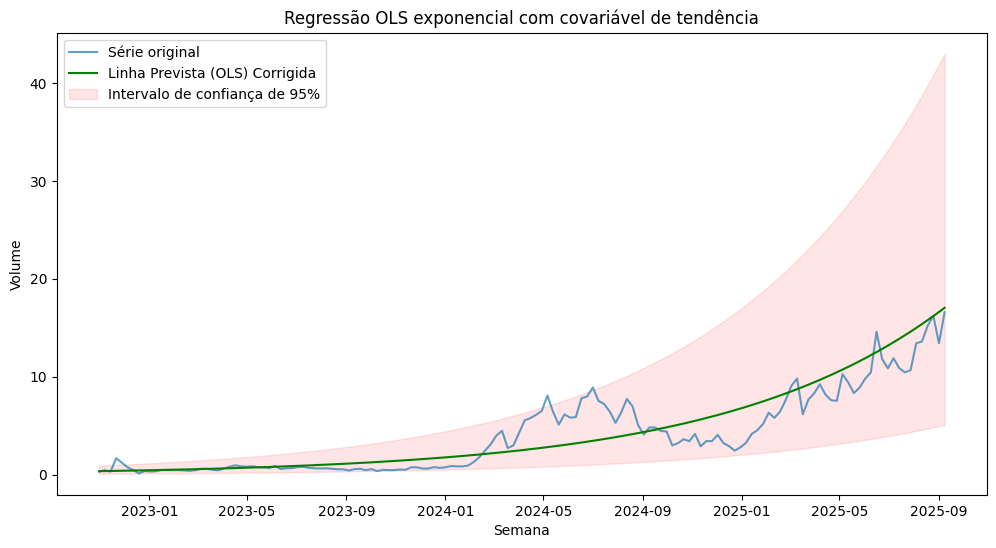

In [34]:
predictions_summary = ols_model_exponential.get_prediction(X).summary_frame(alpha = 0.05)
ln_y_upper = predictions_summary["obs_ci_upper"]
ln_y_lower = predictions_summary["obs_ci_lower"]

ln_y_mean = predictions_summary["mean"]

# Variância residual do ajuste
mse_resid = ols_model_exponential.mse_resid

# Fator de correção da transformação da predição para a escala original
correction_factor = np.exp(mse_resid / 2)

# Calculando a predição na escala original
predicted_original_scale_corrected = np.exp(ln_y_mean) * correction_factor

y_upper_ci = np.exp(ln_y_upper)
y_lower_ci = np.exp(ln_y_lower)

plt.figure(figsize = (12, 6))
plt.plot(data_series.index, data_series, label = 'Série original', alpha = 0.7)
plt.plot(data_series.index, predicted_original_scale_corrected, color = 'green', linestyle = '-', label = 'Linha Prevista (OLS) Corrigida')
plt.fill_between(data_series.index, y_lower_ci, y_upper_ci, color = "red", alpha = 0.1, label = "Intervalo de confiança de 95%")
plt.title('Regressão OLS exponencial com covariável de tendência')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.show()

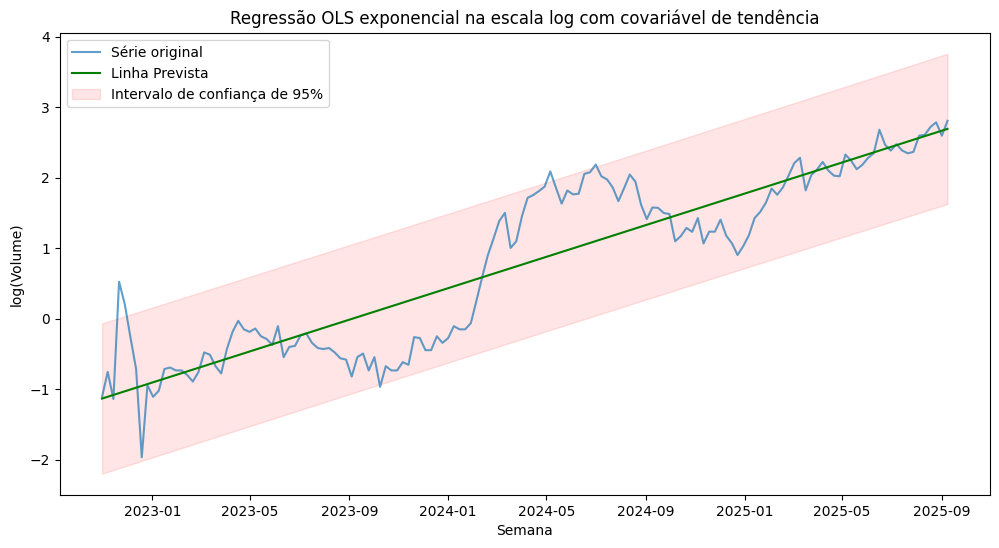

In [38]:
plt.figure(figsize = (12, 6))
plt.plot(data_series.index, np.log(data_series), label = 'Série original', alpha = 0.7)
plt.plot(data_series.index, ln_y_mean, color = 'green', linestyle = '-', label = 'Linha Prevista')
plt.fill_between(data_series.index, ln_y_lower, ln_y_upper, color = "red", alpha = 0.1, label = "Intervalo de confiança de 95%")
plt.title('Regressão OLS exponencial na escala log com covariável de tendência')
plt.xlabel('Semana')
plt.ylabel('log(Volume)')
plt.legend()
plt.show()

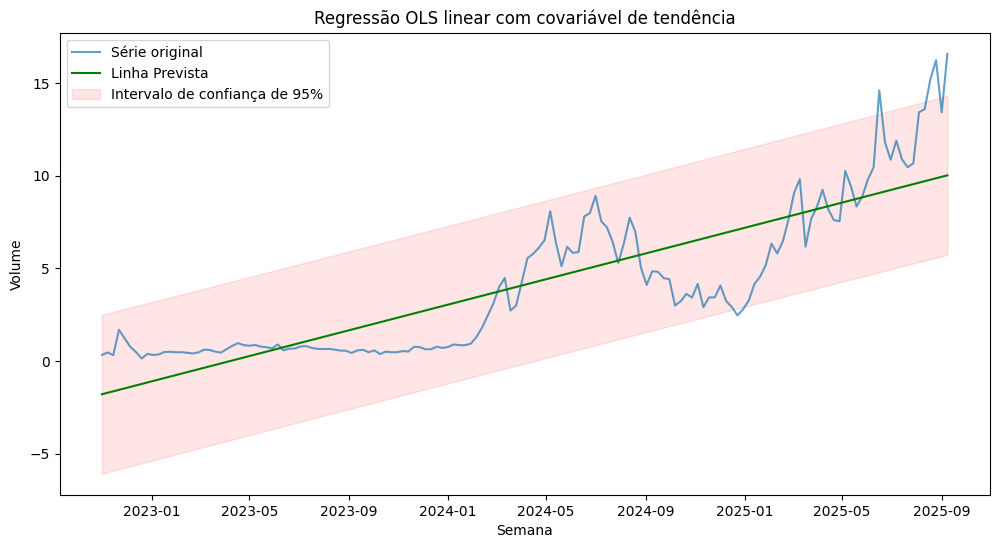

In [35]:
predictions_summary = ols_model_linear.get_prediction(X).summary_frame(alpha = 0.05)
y_upper = predictions_summary["obs_ci_upper"]
y_lower = predictions_summary["obs_ci_lower"]

y_mean = predictions_summary["mean"]

plt.figure(figsize = (12, 6))
plt.plot(data_series.index, data_series, label = 'Série original', alpha = 0.7)
plt.plot(data_series.index, y_mean, color = 'green', linestyle = '-', label = 'Linha Prevista')
plt.fill_between(data_series.index, y_lower, y_upper, color = "red", alpha = 0.1, label = "Intervalo de confiança de 95%")
plt.title('Regressão OLS linear com covariável de tendência')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [25]:
H = X @ np.linalg.inv(X.T @ X) @ X.T

residuals_ols_linear = ols_model_linear.resid
residuals_ols_exponential = predicted_original_scale_corrected - original_y.values

loocv_linear = (1/data_series.size) * np.sum((residuals_ols_linear/(1 - np.diag(H)))**2)
loocv_exponential = (1/data_series.size) * np.sum((residuals_ols_exponential/(1 - np.diag(H)))**2)

print("LOOCV linear:", loocv_linear)
print("LOOCV exponencial:", loocv_exponential)

LOOCV linear: 4.672490389592039
LOOCV exponencial: 3.7547292879888


In [26]:
rmse_ols_linear = np.sqrt(np.mean(residuals_ols_linear**2))
rmse_ols_exponential = np.sqrt(np.mean(residuals_ols_exponential**2))

print("RMSE linear:", rmse_ols_linear)
print("RMSE exponencial:", rmse_ols_exponential)

RMSE linear: 2.1282066123041994
RMSE exponencial: 1.915440858377321


In [29]:
def winkler_score(y_true, y_lower, y_upper, alpha = 0.05):
    # Largura do intervalo
    width = y_upper - y_lower
    
    # Observação abaixo do limite inferior
    penalty_lower = np.where(y_true < y_lower, (2 / alpha) * (y_lower - y_true), 0)
    
    # Observação acima do limite superior
    penalty_upper = np.where(y_true > y_upper, (2 / alpha) * (y_true - y_upper), 0)
    
    # Score por ponto
    score_per_point = width + penalty_lower + penalty_upper
    
    # Mean Winkler Interval Score (MWIS)
    mwis = np.mean(score_per_point)
    
    return mwis

In [31]:
predictions_summary_linear = ols_model_linear.get_prediction(X).summary_frame(alpha = 0.05)
y_upper_linear = predictions_summary_linear["obs_ci_upper"]
y_lower_linear = predictions_summary_linear["obs_ci_lower"]

predictions_summary_exponential = ols_model_exponential.get_prediction(X).summary_frame(alpha = 0.05)
y_upper_exponential = np.exp(predictions_summary_exponential["obs_ci_upper"])
y_lower_exponential = np.exp(predictions_summary_exponential["obs_ci_lower"])

wrinkler_score_ols_linear = winkler_score(data_series.values, y_lower_linear, y_upper_linear)
wrinkler_score_ols_exponential = winkler_score(data_series.values, y_lower_exponential, y_upper_exponential)

print("Wrinkler Score linear:", wrinkler_score_ols_linear)
print("Wrinkler Score exponencial:", wrinkler_score_ols_exponential)

Wrinkler Score linear: 10.448601765356278
Wrinkler Score exponencial: 10.266987909043632
